## Chapter 7 Context analysis

### Preprocessing text

Data Preprocessing
Before we start, here is the list of Text Preprocessing Steps:

- Regular Expression/Normalization — lowercase the words, remove punctuation and remove numbers
- Tokenization — a process of splitting the text into smaller pieces called tokens
- Stop Words Removal — a set of commonly used words in any language
- Lemmatization — a process of grouping together the inflected forms of a word so they can be analyzed as a single item
- *Stemming — a process of grouping together the inflected forms of a word so they can be analyzed as a single item

In [41]:
from deep_translator import GoogleTranslator
import re
import pandas as pd
import json
import os
from math import pi
import numpy  as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import preprocessor as p
from nltk.tokenize import TweetTokenizer
from gensim.parsing.preprocessing import remove_stopwords

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /Users/sha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
twitter_data_dir = "tweets/"
account_data_dir = "tweets/translated_account_city/"
account_files = [f for f in os.listdir(account_data_dir) if f.endswith('.csv')]
search_data_dir = "tweets/translated_search_city/"
search_files = [f for f in os.listdir(search_data_dir) if f.endswith('.csv')]

In [5]:
def preprocessing_data(types,files,data_dir):
    punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@' +'#'
    tokenizer=TweetTokenizer()
    lemmatizer = WordNetLemmatizer()


    for i in range(len(files)):
            f = files[i]

            df_tweets = pd.read_csv(data_dir+f,low_memory=False)
            if 'translated_rt' in df_tweets.keys():
                df_tweets.loc[ df_tweets['translated_rt'].isna(),'translated_rt'] = ''
            else:
                df_tweets['translated_rt'] = ''

            df_tweets.loc[ df_tweets['translated_org'].isna(),'translated_org'] = ''
            df_tweets['translated_text'] = df_tweets[['translated_org', 'translated_rt']].apply(lambda x: ''.join(x), axis=1)


            #clean tweets url mention etc.
            # p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY ,p.OPT.NUMBER) #Hashtag won't be removes
            df_tweets['text_processed'] = df_tweets['translated_text'].apply(str).map(lambda x: p.clean(x))

            #lower case
            df_tweets['text_processed'] = df_tweets['text_processed'].map(lambda x: x.lower())
            # strip punctuation and remove double spacing
            df_tweets['text_processed'] = df_tweets['text_processed'].map(lambda x: re.sub('[' + punctuation + ']+', ' ', x))
            df_tweets['text_processed'] = df_tweets['text_processed'].map(lambda x: re.sub('\s+', ' ', x))

            #remove stop words
            df_tweets['text_processed'] = df_tweets['text_processed'].map(lambda x: remove_stopwords(x))

            #tockenize
            df_tweets['text_processed'] = df_tweets['text_processed'].map(lambda x: tokenizer.tokenize(x))

            #lemmatization
            df_tweets['text_processed'] = df_tweets['text_processed'].map(lambda x: [lemmatizer.lemmatize(word, pos = "v") for word in x if len(word)>2])
            tweets_storage_file = twitter_data_dir + "processed_"+types+"_tweets/"+ "processed_" + f 
            df_tweets[['id','user','translated_text','text_processed']].to_csv(tweets_storage_file,index=False)
            print(tweets_storage_file)


In [16]:
preprocessing_data('account',account_files,account_data_dir)
preprocessing_data('search',search_files,search_data_dir)

### Topic modelling - BERTopic

-  with some tricks
https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#lightweight-installation

- usage
https://grabngoinfo.com/hyperparameter-tuning-for-bertopic-model-in-python/
https://www.vennify.ai/bertopic-topic-modeling/

In [19]:
account_data_dir = "tweets/processed_account_tweets/"
account_files = [f for f in os.listdir(account_data_dir) if f.endswith('.csv')]
search_data_dir = "tweets/processed_search_tweets/"
search_files = [f for f in os.listdir(search_data_dir) if f.endswith('.csv')]

In [21]:
# Traine model

import plotly.io as pio
import umap.umap_ as umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic import BERTopic


vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words="english")
# reduce the impact of frequent words
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Create representation model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.2)

# Create a sentence transformer model
sentence_model = SentenceTransformer('cardiffnlp/twitter-roberta-base')
pca_model = PCA(n_components=20)
kmeans_model = KMeans(n_clusters=14)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10,
                                min_samples=1,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)
account_topics_all_city = pd.DataFrame()

list_of_model = []
city_list = []

for f in account_files:
    city_name = f.split('_')[1]

    # Load  Twitter data into a pandas DataFrame
    df_tweets = pd.read_csv((account_data_dir+f))
    
    # Create a sentence transformer model
    sentence_model = SentenceTransformer('cardiffnlp/twitter-roberta-base')
    topic_model = BERTopic(embedding_model=sentence_model,
                           ctfidf_model=ctfidf_model,
                           representation_model = KeyBERTInspired,
                           vectorizer_model=vectorizer_model,
                           # min_topic_size=50,
                           nr_topics = 'auto',
                           # umap_model=umap_model,hdbscan_model=kmeans_model)
                           hdbscan_model=kmeans_model,
                           umap_model=pca_model)
    
   
    #  'translated_text' is the column that contains the text of tweets
    docs= df_tweets['translated_text'].dropna().astype(str)
     # Fit the model to your data
    topics, probabilities = topic_model.fit_transform(docs)

    # Get the most frequent topics
    topic_freq = topic_model.get_topic_info(); 
    topic_freq.to_csv('BERTopics2/'+city_name+'_BERTopics.csv',index=False)

    # topic_model.visualize_topics()
    fig=topic_model.visualize_barchart(title = city_name+'_topic_score')# n_words=10,top_n_topics = 10
    fig.show()
    # Save the figure as a png image:
    pio.write_image(fig, 'BERTopics2/'+city_name+'topic_model.png')
    
    topic_freq['city_name'] = city_name
    account_topics_all_city = pd.concat([account_topics_all_city,topic_freq])
    
    city_list += [city_name]
    list_of_model += [topic_model]
    
account_topic_model = pd.DataFrame({ 'city': city_list, 'model': list_of_model })

In [ ]:
# using visualization to merge topics 
for i in range(len(account_topic_model)):
    topic_model = account_topic_model.loc[i,'model']
    city_name = account_topic_model.loc[i,'city']


    fig0 = topic_model.visualize_topics()
    pio.write_image(fig0, city_name+'account_distance.png')
    fig0.show()


    docs_file_name = [f for f in account_files if city_name in f][0]
    docs = pd.read_csv(account_data_dir+docs_file_name)['translated_text'].dropna().astype(str)

    Hierarchical topics
    linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
    hierarchical_topics = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)
    hierarchical_topics.to_csv('BERTopics2/'+city_name+'_hierarchical.csv')

    fig1 = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
    pio.write_image(fig1, 'BERTopics2/'+city_name+'_hierarchical.png')
    fig1.show()

    fig2=topic_model.visualize_barchart(title = city_name+'_topic_score',n_words=10,height=500)# n_words=10,top_n_topics = 10
    fig2.show()
    pio.write_image(fig2, "BERTopics2/"+city_name+'account_topic_model.png')
    topic_freq = topic_model.get_topic_info() 
    topic_freq.to_csv("BERTopics2/"+city_name+'_account.csv',index=False)


### sentimental analysis
https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import os
import re
import json
import pandas as pd
import preprocessor as p
from gensim.corpora import Dictionary

In [26]:
account_data_dir = "tweets/topically_processed_account_tweets/"
account_files = [f for f in os.listdir(account_data_dir) if f.endswith('.csv')]
search_data_dir = "tweets/topically_processed_search_tweets/"
search_files = [f for f in os.listdir(search_data_dir) if f.endswith('.csv')]

In [27]:
df_sentimental_analysis = pd.DataFrame(columns = ["user", "senti_text_processed", "sentimenal_res"])

In [28]:
# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

In [ ]:
def sentiment_analysis(types,files,data_dir):
    for f in files:
            df_tweets = pd.read_csv(data_dir+f,low_memory=False)
            df_tweets = df_tweets.dropna(subset=['translated_text']).reset_index()
            city = f.split('_')[1]

            df_sentimental_analysis = pd.DataFrame(columns = ["user", "senti_text_processed", "sentimenal_res"])
            # df_tweets['senti_text_processed'] = df_tweets[full_text_columns].apply(str).map(lambda x: p.clean(x))
            df_tweets['senti_text_processed']  = df_tweets['translated_text'] 

            for i in range(len(df_tweets)):

                tweet_proc = df_tweets.senti_text_processed[i]

                # sentiment analysis
                encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
                # # output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
                output = model(**encoded_tweet)

                scores = output[0][0].detach().numpy()
                scores = softmax(scores)

                senti_res = {} 
                for j in range(len(scores)):
                    senti_res[labels[j]] = scores[j]

                new_row = [city,tweet_proc,senti_res]
                df_sentimental_analysis.loc[len(df_sentimental_analysis)] = new_row
                #save df_sentimental_analysis
                df_sentimental_analysis.to_csv("senti_res3_"+types+"/"+city+"senti_rest.csv",index=False)



In [37]:
sentiment_analysis('account',account_files,account_data_dir)
sentiment_analysis('search',search_files,search_data_dir)

In [38]:
def senti_data_for_plot(types):
    df_res = pd.DataFrame()
    res_dir = 'senti_res3_'+types+'/'
    all_res_files = os.listdir(res_dir)
    for f in all_res_files:
        df_res = pd.concat([df_res,pd.read_csv(res_dir+f)]) 

    df_res.sentimenal_res = df_res.sentimenal_res.map(lambda x: eval(x))
    df_res['Sentimental_label'] = df_res.sentimenal_res.map(lambda A: max(A, key=A.get))
    plot_res = df_res[['user','Sentimental_label']].groupby('user').apply(lambda x: 100*(x.Sentimental_label.value_counts()/x.Sentimental_label.count()))
    plot_res = plot_res.reset_index(name="senti_pre")
    plot_res = plot_res.rename(columns={"user": "City"})
    plot_res[plot_res.Sentimental_label == 'Positive'].sort_values('senti_pre')
    return plot_res

In [39]:
plot_res_account = senti_data_for_plot('account')
plot_res_search = senti_data_for_plot('search')

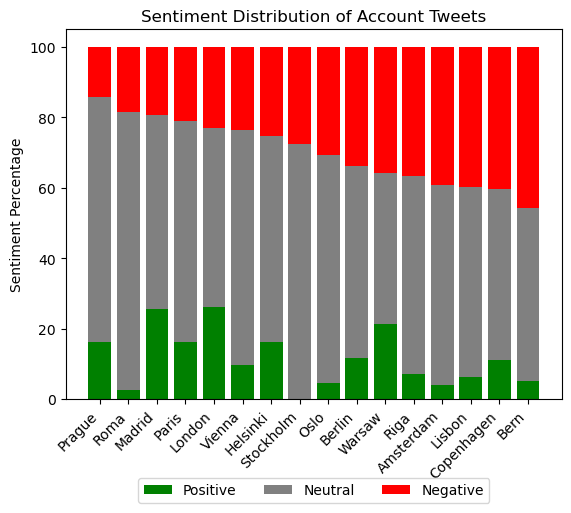

In [43]:

df = plot_res_account.copy()
# Define the cities in the desired order based on the value of senti_pre for Negative sentiment
city_order = df[df['Sentimental_label'] == 'Negative'].sort_values('senti_pre')['City'].tolist()

# Create a dictionary to store the sentiment percentages for each city
sentiment_data = {}
sentiments = ['Positive', 'Neutral', 'Negative']

# Iterate over each city
for city in city_order:
    # Filter the DataFrame for the current city
    city_df = df[df['City'] == city]
    
    # Retrieve the sentiment percentages for the current city
    sentiment_percentages = city_df.set_index('Sentimental_label')['senti_pre'].to_dict()
    
    # Store the sentiment percentages in the dictionary
    sentiment_data[city] = sentiment_percentages

# Create a list of colors for each sentiment
colors = ['green', 'gray', 'red']

# Set the width of the bars
bar_width = 0.5

# Set the position of the bars on the x-axis
x_pos = np.arange(len(city_order))

# Plot the stacked bars for each sentiment
bottom = np.zeros(len(city_order))

for i, sentiment in enumerate(sentiments):
    percentages = [sentiment_data[city][sentiment] for city in city_order]
    plt.bar(x_pos, percentages, bottom=bottom, color=colors[i], label=sentiment)
    bottom += percentages

# Set the x-axis labels
plt.xticks(x_pos, city_order, rotation=45,ha='right')

# Set the y-axis label
plt.ylabel('Sentiment Percentage')

# Set the chart title
plt.title('Sentiment Distribution of Account Tweets')

# Add a legend
# plt.legend()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(sentiments))

plt.savefig("plots/senti_account.png", bbox_inches='tight')
plt.show()


In [44]:
plot_res_account

,City,Sentimental_label,senti_pre
0,Amsterdam,Neutral,56.777108
1,Amsterdam,Negative,39.186747
2,Amsterdam,Positive,4.036145
3,Berlin,Neutral,54.694055
4,Berlin,Negative,33.762476
5,Berlin,Positive,11.543469
6,Bern,Neutral,49.088191
7,Bern,Negative,45.829596
8,Bern,Positive,5.082212
9,Copenhagen,Neutral,48.621990


In [45]:
df_pivot_account = plot_res_account.pivot(index='City', columns='Sentimental_label', values='senti_pre')
df_pivot_search = plot_res_search.pivot(index='City', columns='Sentimental_label', values='senti_pre')

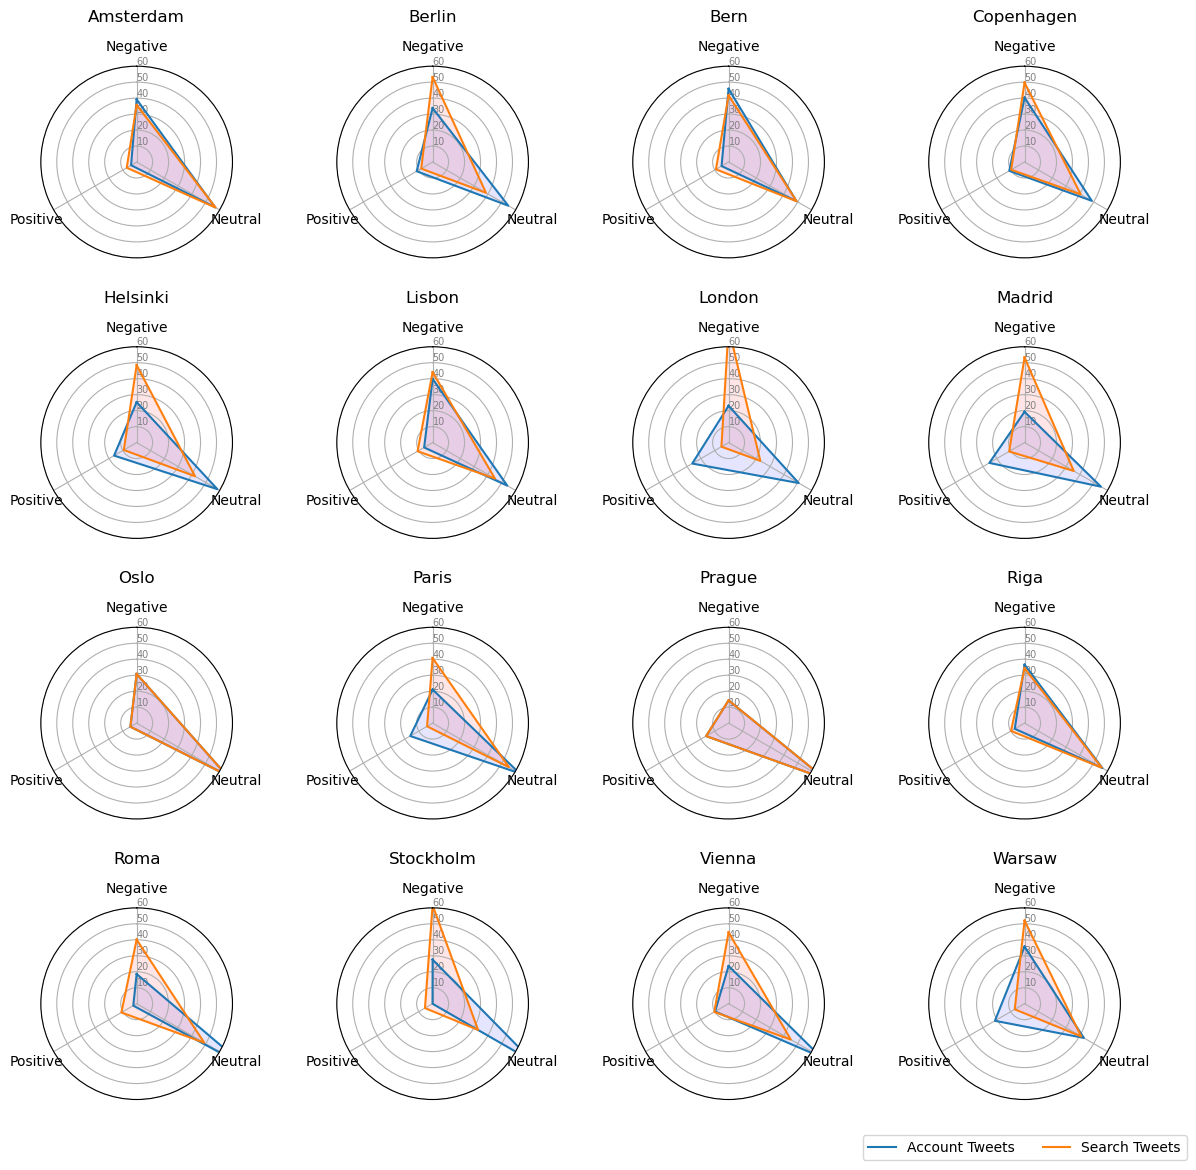

In [46]:
numbers = list(range(10, 101, 10))
numbers_as_strings = [str(num) for num in numbers]
    
# Create a 4x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Initialize the legend
legend_added = False

# Iterate over each city
for i, city in enumerate(df_pivot_account.index):
    # Get the corresponding row from df_pivot_acc and df_pivot_res
    acc_row = df_pivot_account.loc[city].to_dict()
    acc_row['group'] = 'Account Tweets'

    res_row = df_pivot_search.loc[city].to_dict()
    res_row['group'] = 'Search Tweets'

    # Create a new dataframe combining the account and search rows
    df = pd.concat([pd.DataFrame(acc_row, index=[0]), pd.DataFrame(res_row, index=[1])])

    # Set the current axes for the subplot
    ax = axs[i // 4, i % 4]

    # ------- PART 1: Create background

    # Number of variables
    categories = list(df)[:3]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variables)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(4, 4, i + 1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)

    

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(numbers, numbers_as_strings, color="grey", size=7)
    plt.ylim(0, 60)

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't make a loop because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values = df.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', label="Account Tweets")
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values = df.loc[1].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', label="Search Tweets")
    ax.fill(angles, values, 'r', alpha=0.1)

    # Add title to the subplot
    ax.set_title(city, pad=30, va='bottom')

    # if not legend_added:
    #     ax.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    #     legend_added = True
        

ax.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=2)
# Adjust the spacing between subplots
fig.tight_layout()
plt.savefig("plots/senti_each.png", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
